In [52]:
import pandas

In [53]:
sids = ['PF5T', 'WW2T', 'KP6T', 'LV2T', 'FMFT', 'HCBT', 'TS6T', 'UM2T', 'MRCT', 'NM3T', 'SPGT', 'ZK4T', 'GAIT', 'DA9T', 'VL1T']

In [54]:
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

In [63]:
def get_signal(subject_id, mask, run, source='highpassed_motion'):

    
    if source == 'highpassed':
        signal = np.loadtxt('/home/gdholla1/data/bias_task/extracted_timeseries/highpassed/_mask_%s_subject_id_%s/_extracter_highpassed%d/run%d_unwarped_st_dtype_mcf_mask_gms_tempfilt_maths_ts.txt' % (mask, subject_id, run-1, run))
        
    elif source == 'highpassed_cardiac':
        signal = np.loadtxt('/home/gdholla1/data/bias_task/extracted_timeseries/highpassed_cardiac/_mask_%s_subject_id_%s/_extracter_cardiac%d/run%d_unwarped_maths_st_dtype_mcf_mask_gms_tempfilt_maths_ts.txt' % (mask, subject_id, run-1, run))
        
    elif source == 'highpassed_motion':
        signal = np.loadtxt('/home/gdholla1/data/bias_task/extracted_timeseries/highpassed_motion/_mask_%s_subject_id_%s/_extracter_highpassed_motion%d/run%d_unwarped_st_dtype_mcf_mask_gms_tempfilt_regfilt_maths_ts.txt' % (mask, subject_id, run-1, run))

    elif source == 'highpassed_cardiac_motion':
        signal = np.loadtxt('/home/gdholla1/data/bias_task/extracted_timeseries/highpassed_cardiac_motion/_mask_%s_subject_id_%s/_extracter_cardiac_motion%d/run%d_unwarped_maths_st_dtype_mcf_mask_gms_tempfilt_regfilt_maths_ts.txt' % (mask, subject_id, run-1, run))        

    signal = (signal / signal.mean()) * 100
    signal -= signal.mean()


    return signal


def get_onsets(subject_id, run, design='model3', shift=0):

    df = pandas.read_pickle('/home/gdholla1/data/bias_task/behavior/behavior.pandas')
    df = df[(df.subj_idx == subject_id) & (df.block == run)]

    df['onset_cue'] += shift
    df['onset_stim'] += shift
    
    onsets_cue = df.onset_cue.tolist()
    onsets_stim = df.onset_stim.tolist()
        
    if design == 'model3':

        conditions=['onsets_cue',
                    'onsets_stim',]
        
        onsets=[onsets_cue,
                onsets_stim]
        
    elif design == 'cue_only':
        conditions=['onsets_cue',]
        
        onsets=[onsets_cue]  
        
    elif design == 'stim_only':
        conditions=['onsets_stim',]
        
        onsets=[onsets_stim]
        
    return dict(zip(conditions, onsets))

In [72]:
level2_dict = []
adj_r = []

for subject_id in sids:
    
    for model in ['model3', 'cue_only', 'stim_only']:
    
        for source in ['highpassed_motion', 'highpassed_cardiac_motion']:

            if subject_id == 'KCAT':
                runs = [1,2]
            else:
                runs = [1,2,3]

            for run in runs:


                onsets_dict = get_onsets(subject_id, run, model)
                pars = onsets_dict.keys()

                conditions = []
                onsets = []

                for key in onsets_dict.keys():
                    conditions += [key] * len(onsets_dict[key])
                    onsets += onsets_dict[key]

                paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                                onset=onsets,
                                                                duration=[[1.]] * len(conditions))
                tr = 3.0
                frametimes = np.linspace(0, 387 * tr, 387)
                hrf_model = 'Canonical with Derivative'

                X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

                X /= X.max(0)
                X = pandas.DataFrame(X, columns=names)

                for i, mask in enumerate(['STh_L', 'STh_R']):

                    try:
                        signal = get_signal(subject_id,  mask, run, source=source)
                        r = sm.GLSAR(signal, X).iterative_fit()

                        adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run, 'source':source, 'model':model})

                        for par in pars:
                            level2_dict.append({'value':r.params[par],
                                                'par':par,
                                                'subject_id':subject_id,
                                                'mask':mask,
                                                'run':run,
                                                'source':source,
                                                'model':model})
                    except Exception as e:
                        print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: FMFT/STh_L/endog and exog matrices are different sizes
Error: FMFT/STh_R/endog and exog matrices are different sizes
Error: FMFT/STh_L/endog and exog matrices are different sizes
Error: FMFT/STh_R/endog and exog matrices are different sizes
Error: FMFT/STh_L/endog and exog matrices are different sizes
Error: FMFT/STh_R/endog and exog matrices are different sizes


In [73]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm.ix[df_glm['mask'] == 'STh_L', 'mask'] = 'STN_L'
df_glm.ix[df_glm['mask'] == 'STh_R', 'mask'] = 'STN_R'

df_glm['% signal change'] = df_glm['value']

In [74]:
adj_r = pandas.DataFrame(adj_r)

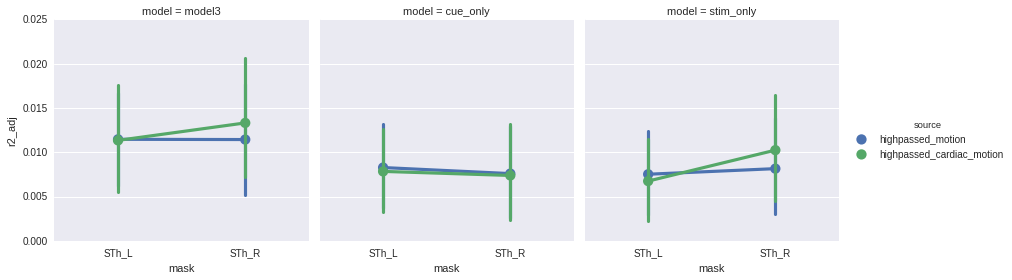

In [78]:
sns.factorplot('mask', 'r2_adj', 'source', col='model', data=adj_r)

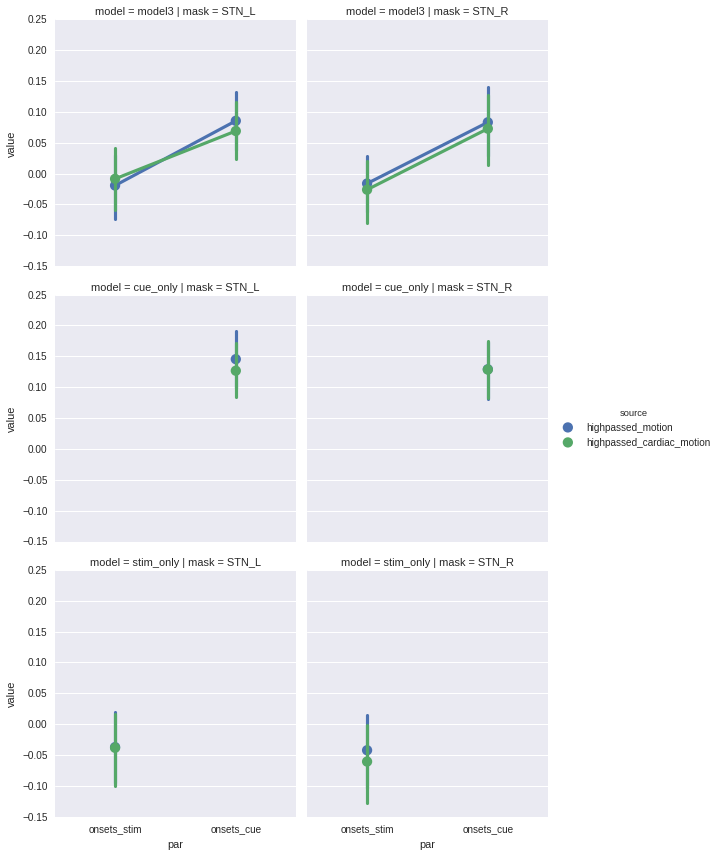

In [97]:
sns.factorplot('par', 'value', 'source', row='model', col='mask', data=df_glm)

In [91]:
tmp = df_glm.pivot_table(index='subject_id', columns=['source', 'model', 'mask', 'par'], values='value')

t, p = sp.stats.ttest_rel(tmp['highpassed_cardiac_motion'], tmp['highpassed_motion'])

In [94]:
tmp

source     highpassed_cardiac_motion                                    \
model                       cue_only                model3               
mask                           STN_L      STN_R      STN_L               
par                       onsets_cue onsets_cue onsets_cue onsets_stim   
subject_id                                                               
DA9T                        0.025828   0.110336  -0.126957   -0.007538   
FMFT                        0.125038   0.093143   0.086335    0.001846   
GAIT                        0.167728   0.248903   0.097874   -0.072811   
HCBT                        0.054684   0.100112   0.059897   -0.044052   
KP6T                        0.021151   0.042991  -0.021734    0.026841   
LV2T                        0.185073   0.293714   0.144635   -0.006204   
MRCT                        0.186873   0.092570   0.092363   -0.012669   
NM3T                        0.166837   0.063377   0.245515   -0.115265   
PF5T                        0.192245  -0.058910   0.093264   -0.079998   
SPGT                        0.166763   0.227119   0.089482    0.077893   
TS6T                        0.130875   0.043987   0.055985   -0.034581   
UM2T                        0.461868   0.420500   0.413403   -0.188694   
VL1T                       -0.107983   0.133212  -0.064492    0.104293   
WW2T                        0.072390   0.030403  -0.041006    0.087038   
ZK4T                        0.050117   0.074734  -0.083333    0.140471   

source                                                    highpassed_motion  \
model                               stim_only                      cue_only   
mask            STN_R                   STN_L       STN_R             STN_L   
par        onsets_cue onsets_stim onsets_stim onsets_stim        onsets_cue   
subject_id                                                                    
DA9T        -0.081432    0.062020    0.079521    0.083260          0.005972   
FMFT         0.089229    0.139937   -0.053534    0.112651          0.195552   
GAIT         0.124788   -0.113360   -0.090764   -0.121155          0.171207   
HCBT         0.036838   -0.136673   -0.073526   -0.140622          0.104642   
KP6T        -0.090573    0.079192    0.113738    0.064643          0.025811   
LV2T         0.301312   -0.230094   -0.061178   -0.207993          0.147515   
MRCT         0.097317   -0.003740   -0.081625    0.008520          0.224073   
NM3T         0.058257    0.026623   -0.038526    0.007138          0.164445   
PF5T        -0.014141   -0.050638   -0.153488   -0.073780          0.224888   
SPGT         0.128761    0.005644    0.032917   -0.029168          0.181852   
TS6T         0.041494   -0.031908    0.064040    0.069970          0.113368   
UM2T         0.500048   -0.308586   -0.473514   -0.680498          0.470805   
VL1T         0.104506    0.040704   -0.027881   -0.042450         -0.076615   
WW2T        -0.145098    0.079314    0.051056   -0.019816          0.132555   
ZK4T        -0.053471    0.105991    0.134591    0.119198          0.095376   

source                                                               \
model                     model3                                      
mask            STN_R      STN_L                  STN_R               
par        onsets_cue onsets_cue onsets_stim onsets_cue onsets_stim   
subject_id                                                            
DA9T         0.103312  -0.146690   -0.030697  -0.060328    0.075277   
FMFT        -0.105957   0.089968   -0.227436  -0.067003    0.008675   
GAIT         0.276264   0.084860   -0.070716   0.144429   -0.071629   
HCBT         0.179180   0.099945    0.009340   0.123569   -0.086011   
KP6T         0.002392  -0.023486    0.014846  -0.115276    0.068202   
LV2T         0.324598   0.151576    0.019030   0.373231   -0.132994   
MRCT         0.104968   0.133590   -0.009242   0.103099    0.017490   
NM3T         0.073723   0.220872   -0.104679   0.078615    0.018722   
PF5T        -0.

In [ ]:
from 

In [95]:
pandas.DataFrame({'t':t, 'p':p}, index=tmp.columns[:8])

p         t
source                    model     mask  par                            
highpassed_cardiac_motion cue_only  STN_L onsets_cue   0.035626 -2.324894
                                    STN_R onsets_cue   0.939453 -0.077333
                          model3    STN_L onsets_cue   0.025992 -2.489427
                                          onsets_stim  0.542071  0.624927
                                    STN_R onsets_cue   0.514917 -0.668127
                                          onsets_stim  0.643052 -0.473648
                          stim_only STN_L onsets_stim  0.904236 -0.122511
                                    STN_R onsets_stim  0.237702 -1.233490